## Test WCS for corner sensors

Aim: solve the problem why when providing a set of x,y pixels, I see an offset in PhoSim images of where they are supposed to be.
   
minimal code from `baseAOSLoop.py`
        
        
        xPx = [200,500,1000]
        yPx = [1000,2000,3000]
        # skySim= self._prepareSkySimByChipPos(sensorNameList,raInDeg,
        #     decInDeg,rotAngInDeg,
        #     starMag,xPx=xPx,yPx=yPx)
        skySim = SkySim()

        skySim.setObservationMetaData(raInDeg, decInDeg, rotSkyPos, mjd)

        starId = 0 
        for sensor in sensorName:
            for i in range(len(xPx)):
                skySim.addStarByChipPos(sensor, starId, xPx[i],
                                        yPx[i], starMag)
                starId += 1 


The stars were simulated with the following one-liner that can be copy-pasted to the terminal : 

In [3]:
import os
import argparse
import numpy as np

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use('dark_background')

import sys
sys.path.append('../analysis_tools/')
import analysisTools as at

topDir = '/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs'
outputDir = os.path.join(topDir,'baselineTest_2020_24_noBkgnd_noContam')

cmd = 'python baseAOSLoop.py'
numPro = 20
iterNum = 5
opdCmdSettingsFile = 'opdDefault.cmd'
# I use that to match the beginning of the star cmd file below.
# this opdDefault.cmd has : 
# 
#         backgroundmode 0
#         raydensity 0.0
#         perturbationmode 1

starCmdSettingsFile = 'starDefault.cmd'
# starDefault.cmd   has  : 
# 
#         backgroundmode 0
#         raydensity 0.0
#         perturbationmode 1
#
#         trackingmode 0
#         cleartracking
#         clearclouds
#         lascatprob 0.0
#         contaminationmode 0  <-- no contam  ! 
#         diffractionmode 1
#         straylight 0
#         detectormode 0
#         centroidfile 1

selectSensors = 'lsstcam'
#skyFilePath = os.path.join(topDir, 'skyWfsArrow.txt')

args = '--numPro %d --iterNum %d --outputDir %s \
 --opdCmdSettingsFile %s --starCmdSettingsFile %s \
--selectSensors %s --clobber --dbFileName bsc0.db3 '%(numPro, iterNum, outputDir,
            opdCmdSettingsFile, starCmdSettingsFile, selectSensors)
print('\n Run in terminal:')
print('%s %s'%(cmd,args))


 Run in terminal:
python baseAOSLoop.py --numPro 20 --iterNum 5 --outputDir /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/baselineTest_2020_24_noBkgnd_noContam  --opdCmdSettingsFile opdDefault.cmd --starCmdSettingsFile starDefault.cmd --selectSensors lsstcam --clobber --dbFileName bsc0.db3 


The result is  

data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22', 'detector': 197}
Reading postISR images from the following repo_dir:
/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/baselineTest_2020_24_noBkgnd_noContam/input/rerun/run1
Done



Text(0.5, 1.0, 'catalog x,y and the postISR image')

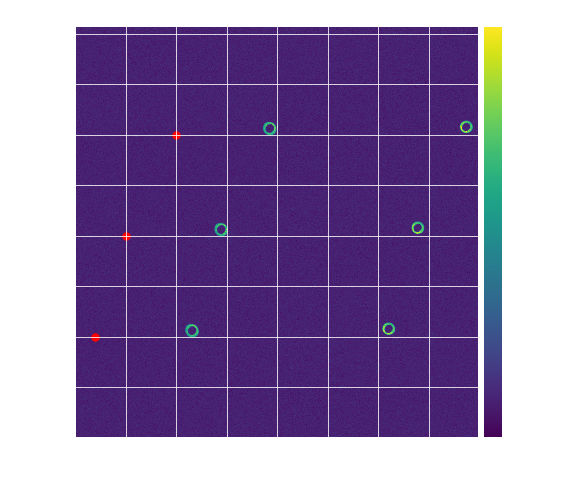

In [24]:
image = at.readImage(outputDir,raft='R00',detector='S22', focalType='intra')
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(8,8))
at.plotImage(image, ax,plotArgs={'vmax':400})
ax.grid()
xPx = [200,500,1000]
yPx = [1000,2000,3000]
ax.scatter(xPx,yPx,s=55,c='r')
ax.set_title('catalog x,y and the postISR image')

So there is an offset between where the donuts are, and where I would expect them to be (red dots).

Investigating the following steps : 

# 1) SkySim: do we get back what we put in ? (x,y <==> ra,dec) 

SkySim uses `lsst.sims.coordUtils.CameraUtils.raDecFromPixelCoords` to get  ra,dec from x,y  .  If we're using `WcsSol.py`, then it uses the converse function `lsst.sims.coordUtils.CameraUtils.pixelCoordsFromRaDec` to get x,y from ra,dec. Check that we recover the input coordinates: 

In [25]:
from astropy.time import Time

In [26]:
t = Time('2000-01-01T00:00:00', format='isot', scale='utc')

In [29]:
t.mjd

51544.0

In [30]:
from lsst.sims.utils import ObservationMetaData

from lsst.sims.coordUtils.CameraUtils import raDecFromPixelCoords
from lsst.sims.coordUtils.CameraUtils import pixelCoordsFromRaDec

from lsst.sims.coordUtils import raDecFromPixelCoordsLSST
from lsst.sims.coordUtils import pixelCoordsFromRaDecLSST

from lsst.obs.lsstSim import LsstSimMapper
from lsst.ts.wep.SourceProcessor import SourceProcessor
from lsst.ts.wep.Utility import expandDetectorName

_sourProc = SourceProcessor()
sensorName = 'R00_S22_C1'
_sourProc.config(sensorName=sensorName)

xInpixelInCam = 200
yInPixelInCam = 1000
print('Cam X,Y: ', xInpixelInCam, yInPixelInCam)
pixelDmX, pixelDmY = _sourProc.camXY2DmXY(xInpixelInCam,
                                          yInPixelInCam)


print('DM X,Y: ', pixelDmX, pixelDmY)
# Expand the sensor name
expandedSensorName = expandDetectorName(sensorName)

# this doesn't change if I set mjd = 51544 which corresponds to the year 2000.0,
# which is the default epoch
t = Time('2000-01-01T00:00:00', format='isot', scale='utc')
mjd = t.mjd
_obs = ObservationMetaData(pointingRA=0, pointingDec=0,
                           rotSkyPos=0, mjd=mjd)
includeDistortion = True

raInDeg, declInDeg = raDecFromPixelCoords(
    pixelDmX, pixelDmY, expandedSensorName, camera=LsstSimMapper().camera,
    obs_metadata=_obs, epoch=2000,
    includeDistortion=includeDistortion)

# # that's an alternative function but it doesn't make a difference ... 
raInDeg_1, declInDeg_1 = raDecFromPixelCoordsLSST(
    pixelDmX, pixelDmY, expandedSensorName,
    obs_metadata=_obs, epoch=2000,
    includeDistortion=includeDistortion)

# if we use WcsSol.py, it's using https://github.com/lsst-ts/ts_wep/blob/uw_dev/python/lsst/ts/wep/bsc/WcsSol.py 
#from lsst.sims.coordUtils.CameraUtils import pixelCoordsFromRaDec

xOut, yOut = pixelCoordsFromRaDec(raInDeg, declInDeg, obs_metadata=_obs,
                                    chipName=expandedSensorName, camera=LsstSimMapper().camera,
                                    epoch=2000.0,
                                    includeDistortion=includeDistortion)

xOut1, yOut1 = pixelCoordsFromRaDecLSST(raInDeg_1, declInDeg_1, obs_metadata=_obs,
                                    chipName=expandedSensorName,
                                    epoch=2000.0,
                                    includeDistortion=includeDistortion)


print('Using lsst.sims.coordUtils.CameraUtils.raDecFromPixelCoords, .pixelCoordsFromRaDec',  xOut,yOut)
print('Using lsst.sims.coordUtils.raDecFromPixelCoordsLSST, .pixelCoordsFromRaDecLSST', xOut1, yOut1)

Cam X,Y:  200 1000
DM X,Y:  1000 1800
Using lsst.sims.coordUtils.CameraUtils.raDecFromPixelCoords, .pixelCoordsFromRaDec 999.9999999910494 1799.9999991912016
Using lsst.sims.coordUtils.raDecFromPixelCoordsLSST, .pixelCoordsFromRaDecLSST 1000.0000016934724 1799.999997676954


So it's quite close. `IncludeDistortion = True`  improves things by few pixels on each end, it is on by default. 

# 2) Given the PhoSim WCS  and catalog ra,dec --> x,y

In [15]:
import lsst.daf.persistence as dafPersist

topDir = '/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs'
outputDir = os.path.join(topDir,'baselineTest_2020_24_noBkgnd_noContam')
data_dir = outputDir

focalType = 'intra'
raft = 'R00'
detector = 'S22'
rerun='run1'
# if Butler args are no provided, attempting to 
# guess based on the following:

sensor = raft+'_'+detector 


# this applies to ComCam ...
detNumDict = {'R22_S00':90, 'R22_S01':91, 'R22_S02':92,   # ComCam detector ids 
              'R22_S10':93, 'R22_S11':94, 'R22_S12':95, 
              'R22_S20':96, 'R22_S21':97, 'R22_S22':98,
              'R00_S22':197,'R04_S20':204,    # WFS detector ids 
              'R40_S02':209, 'R44_S00':216
              }

detNum = detNumDict[sensor]    
# these are decided in baseComcamLoop.py or baseWfsLoop.py 
obsIdDic = {'focal':9006000, 'extra':9006001,  'intra':9006002}

#if not obsId: # if not provided, reading it from a dict, based on the focal type
obsId = obsIdDic[focalType]

# assemble data_id arguments for Butler 
data_id = {'visit': obsId, 'filter': 'g', 'raftName': raft, 
           'detectorName': detector, 'detector': detNum
          }

print('data_id is')
print(data_id)
# Read each figure as a postage stamp, store data to an array 

repo_dir = os.path.join(data_dir, 'input/rerun/', rerun)
print('Reading postISR images from the following repo_dir:')
print(repo_dir)

butler = dafPersist.Butler(repo_dir)

# show what keys are needed by the `postISRCCD` data type.... 
# butler.getKeys('postISRCCD')
# yields {'visit': int, 'filter': str,'raftName': str, 'detectorName': str, 'detector': int}
post = butler.get('postISRCCD', **data_id) 



data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22', 'detector': 197}
Reading postISR images from the following repo_dir:
/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/baselineTest_2020_24_noBkgnd_noContam/input/rerun/run1


Given the WCS from the postISR CCD and the input catalog (ra,dec), we use the WCS to get (x,y):

In [16]:
image = post.image.array
wcs = post.getWcs()

from astropy.table import Table
cat_dir = data_dir
cat_path = os.path.join(cat_dir,'iter0/pert/',  'skyInfo.txt' )
cat = Table.read(cat_path, format='ascii')


# This function was pointed out to me by Eli Rykoff 
# https://github.com/LSSTDESC/supreme/blob/75a2008d203e28b3d42738374823f1f5e42d9db1/supreme/utils.py#L181
# and sparked this https://jira.lsstcorp.org/browse/DM-26485
def radec_to_xy(wcs, ra, dec):
    """
    Convert ra/dec arrays to xy array
    Parameters
    ----------
    wcs : `lsst.afw.geom.SkyWcs`
       WCS object
    ra : `numpy.ndarray`
       Float array of RA positions
    dec : `numpy.ndarray`
       Float array of Dec positions
    Returns
    -------
    xy : `numpy.ndarray`
       2xN array of x/y positions associated with input ra/dec
    """
    xy = wcs.getTransform().getMapping().applyInverse(np.deg2rad(np.vstack((ra, dec))))
    return xy.T


xy = radec_to_xy(wcs, cat['Ra'].data, cat['Decl'].data)

Text(0.5, 1.0, 'catalog ra,dec --> x,y given PhoSim WCS')

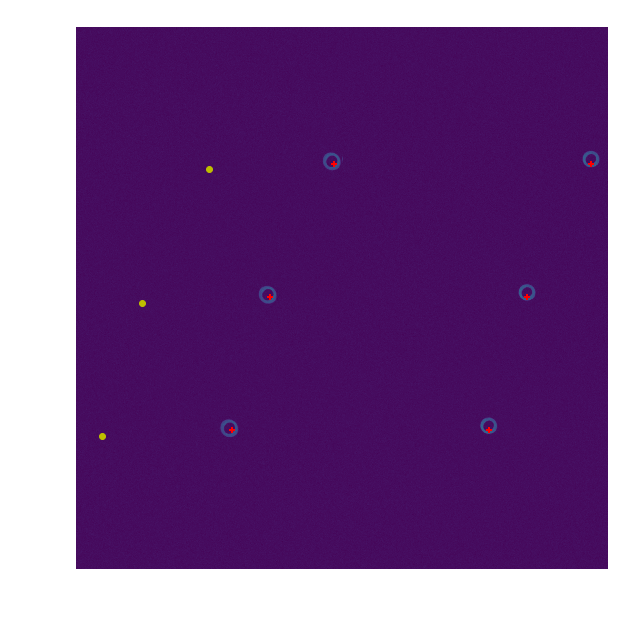

In [23]:

xs = xy[:,0]
ys = xy[:,1]

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(image.T, origin='lower', vmax=1200)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
mx = (0 < xs)*(xs<4000)
my = (0 < ys)*(ys<4000)
mxy = mx*my
args = {'marker':'+', 's':40,'edgecolor':'red', 
         'facecolor':'red', 'linewidth':2}
ax.scatter(ys[mxy],xs[mxy],**args)

xPx = [200,500,1000]
yPx = [1000,2000,3000]
ax.scatter(xPx,yPx, c='y')    
ax.set_title('catalog ra,dec --> x,y given PhoSim WCS')


yellow dots show where we would expect the points to be based on the input. The red crosses show the location of the points given the catalog ra,dec and the PhoSim WCS   